In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

### Summary of DataSet

In [2]:
# Import Data excluding unecessary column INDO
df = pd.read_csv('BodyFat.csv').drop(columns='IDNO')
df.describe()

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,18.938492,1.055574,44.884921,178.924405,70.148810,25.436905,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,7.750856,0.019031,12.602040,29.389160,3.662856,3.648111,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.800000,1.041400,35.750000,159.000000,68.250000,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.000000,1.054900,43.000000,176.500000,70.000000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,45.100000,1.108900,81.000000,363.150000,77.750000,48.900000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


## Correlation between features and target variable

In [3]:
df.corr()['BODYFAT']

BODYFAT      1.000000
DENSITY     -0.988087
AGE          0.289174
WEIGHT       0.613156
HEIGHT      -0.089106
ADIPOSITY    0.727994
NECK         0.491489
CHEST        0.702885
ABDOMEN      0.813706
HIP          0.625700
THIGH        0.561284
KNEE         0.507786
ANKLE        0.266783
BICEPS       0.493031
FOREARM      0.363277
WRIST        0.347573
Name: BODYFAT, dtype: float64

## Relationship between BODYFAT and DENSITY is
BODYFAT = 495 / DENSITY - 450 --> <b>Siri Equation, Siri, 1956<b/>

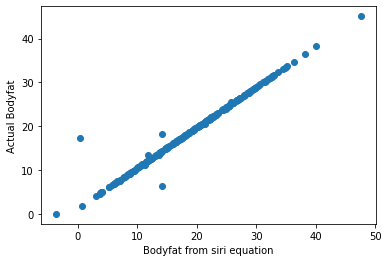

In [5]:
# Given Density as true
expected_bodyfat = (495 / df['DENSITY']) - 450.
errors = df['BODYFAT'] - expected_bodyfat
plt.scatter(expected_bodyfat, df['BODYFAT'])
plt.xlabel('Bodyfat from siri equation')
plt.ylabel('Actual Bodyfat')
plt.show()

## Given the equation, filter out 5-outliers outside of IQR-boxplot range
## Select outliers based on boxplot and the threshold
###### (These five datapoints could be used for final target-value modification and validation usecase)

In [6]:
# Extract outliers based on IQR
IQR = errors.quantile(0.75) - errors.quantile(0.25)
l_bound = errors.quantile(0.25) - (1.5 * IQR)
u_bound = errors.quantile(0.75) + (1.5 * IQR)
df.loc[errors[(errors < l_bound) | (errors > u_bound)].index, ['BODYFAT','DENSITY']]

,BODYFAT,DENSITY
47,6.4,1.0665
75,18.3,1.0666
95,17.3,1.0991
181,0.0,1.1089
215,45.1,0.9950


## Bodyfat looks like following Normal Distribution

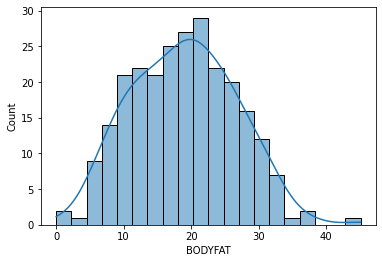

In [7]:
# Histogram for Bodyfat
sns.histplot(df['BODYFAT'], kde=True, bins=20)
plt.show()

## Feature Selection
## Option 0. correlation between features given threshold

In [8]:
# Highly correlated features with respect to absolute value
threshold = 0.9
corr_vals = df.corr().stack()
high_corr = corr_vals[(abs(corr_vals) > threshold) & (corr_vals != 1)]
list_of_high_corr = sorted(high_corr.to_dict().items(), key=lambda x:x[1])[::2]
list_of_high_corr

[(('BODYFAT', 'DENSITY'), -0.9880867267228647),
 (('ADIPOSITY', 'CHEST'), 0.9117986490778514),
 (('CHEST', 'ABDOMEN'), 0.9158276698546787),
 (('ADIPOSITY', 'ABDOMEN'), 0.9238800954811145),
 (('WEIGHT', 'HIP'), 0.9408841249190423)]

## Option 1. Feature Selection using default lasso regression

In [9]:
# Split features and target
X = df[df.columns[~df.columns.isin(['BODYFAT', 'DENSITY'])]]
y = df['BODYFAT']

In [10]:
# Fit lasso and retrieve trained coefficients having zero values
lasso = Lasso()
lasso.fit(X, y)
zero_coef_features = [[lasso.feature_names_in_[idx], val] for idx, val in enumerate(lasso.coef_) if val == 0]
zero_coef_features

[['ADIPOSITY', 0.0],
 ['NECK', -0.0],
 ['CHEST', 0.0],
 ['HIP', -0.0],
 ['KNEE', 0.0],
 ['ANKLE', -0.0],
 ['BICEPS', 0.0],
 ['FOREARM', 0.0],
 ['WRIST', -0.0]]

## Option 2. Feature Selection using 'feature_importances_' attribute from default RF model

In [11]:
# Fit RF and retrieve feature importances from trained model ordered from the lowest importance
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X, y)
feature_importance = [[X.columns[idx], val] for idx, val in enumerate(rf_model.feature_importances_)]
feature_importance.sort(key=lambda x:x[1])
feature_importance

[['FOREARM', 0.013617583584753063],
 ['BICEPS', 0.01588968048349569],
 ['ANKLE', 0.01801359059379894],
 ['KNEE', 0.019814037793929862],
 ['HIP', 0.02084797668573457],
 ['THIGH', 0.021749650337904356],
 ['NECK', 0.022451915837732223],
 ['CHEST', 0.023091791399959087],
 ['ADIPOSITY', 0.023488748879541003],
 ['WEIGHT', 0.024267950567363517],
 ['AGE', 0.024972746623200818],
 ['WRIST', 0.027481985927378418],
 ['HEIGHT', 0.03514384754603382],
 ['ABDOMEN', 0.7091684937391747]]

## Given three options, WEIGHT, HIP can be survied from Option 0. In the meanwhile, duplicated columns from Option 1. with Option 2. would be deleted, which gives us 5-features left --  
# AGE+WEIGHT+HEIGHT+ABDOMEN+WRIST !!!!